# Network Traffic Classification with XGBoost and SHAP
## Comprehensive Analysis: What, Why, How, When, Where, Who

This notebook performs network traffic classification using XGBoost and provides comprehensive explanations using SHAP to answer:
- **WHAT**: What is the traffic classification (attack type or benign)?
- **WHY**: Why was it classified this way (SHAP explanations)?
- **HOW**: How do attacks manifest in the network (patterns)?
- **WHEN**: When do attacks occur (temporal analysis)?
- **WHERE**: Where do attacks originate (network location)?
- **WHO**: Who is attacking (actor profiling)?

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading & Exploration

In [7]:
# Load all CSV files
import glob
import os

data_path = 'MachineLearningCVE'
csv_files = glob.glob(os.path.join(data_path, '*.csv'))

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(f"  - {os.path.basename(f)}")

# Load all data
dfs = []
for file in csv_files:
    print(f"\nLoading {os.path.basename(file)}...")
    df_temp = pd.read_csv(file, encoding='utf-8', low_memory=False)
    print(f"  Shape: {df_temp.shape}")
    dfs.append(df_temp)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)
print(f"\n{'='*60}")
print(f"Combined dataset shape: {df.shape}")
print(f"{'='*60}")

Found 8 CSV files:
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv

Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
  Shape: (225745, 79)

Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
  Shape: (286467, 79)

Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
  Shape: (191033, 79)

Loading Monday-WorkingHours.pcap_ISCX.csv...
  Shape: (529918, 79)

Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
  Shape: (288602, 79)

Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
  Shape: (170366, 79)

Loading Tuesday-WorkingHours.pcap_ISCX.csv...
  Shape: (445909, 79)

Loading Wednesday

In [8]:
# Display basic information
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IA

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Label column: ' Label'

Class distribution:
 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


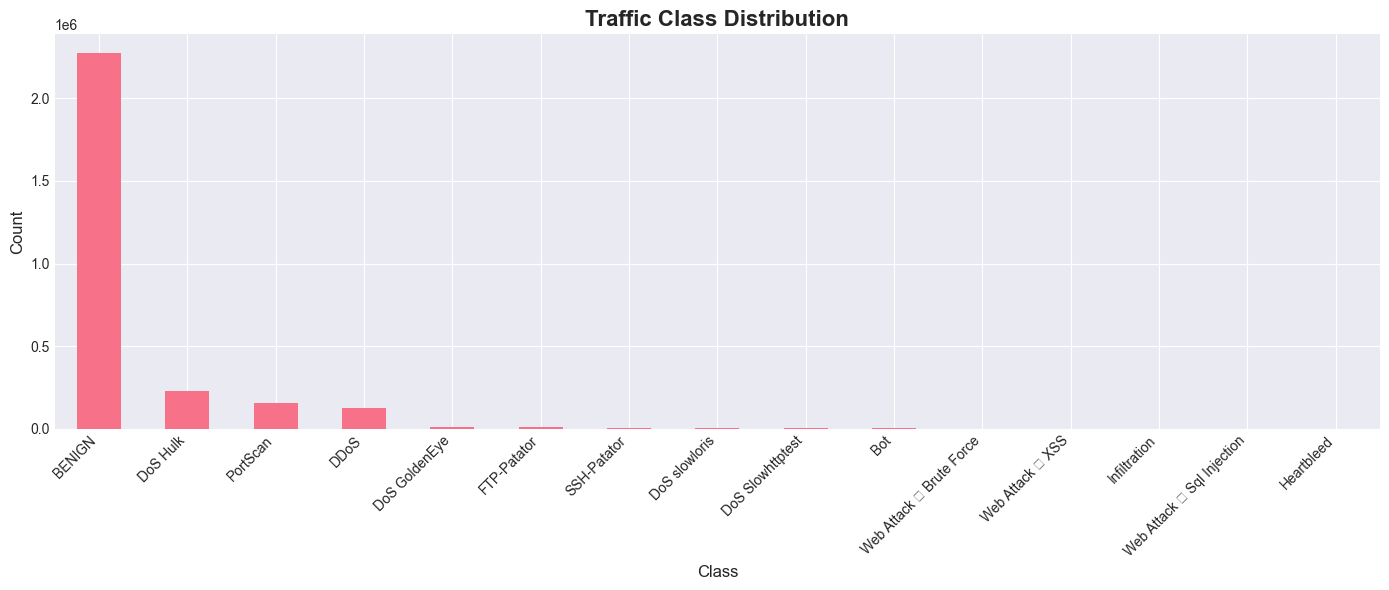

In [9]:
# Check label column (usually 'Label' in CICIDS2017)
label_col = ' Label' if ' Label' in df.columns else 'Label'
print(f"Label column: '{label_col}'")
print(f"\nClass distribution:")
print(df[label_col].value_counts())

# Visualize class distribution
plt.figure(figsize=(14, 6))
df[label_col].value_counts().plot(kind='bar')
plt.title('Traffic Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [10]:
# Clean column names
df.columns = df.columns.str.strip()

# Identify label column
label_col = 'Label'

# Handle missing values
print(f"Missing values before cleaning:")
print(df.isnull().sum().sum())

# Replace inf values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values with median for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

print(f"\nMissing values after cleaning: {df.isnull().sum().sum()}")

Missing values before cleaning:
1358

Missing values after cleaning: 0


In [11]:
# Feature engineering - save temporal and location features for later analysis
temporal_features = []
location_features = []

# Identify feature types
for col in df.columns:
    if 'Timestamp' in col or 'Time' in col:
        temporal_features.append(col)
    if 'Source' in col or 'Destination' in col or 'Port' in col:
        location_features.append(col)

print(f"Temporal features: {temporal_features}")
print(f"Location features: {location_features}")

# Separate features and target
X = df.drop(columns=[label_col] + temporal_features)
y = df[label_col]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nLabel mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"  {i}: {class_name}")

Temporal features: []
Location features: ['Destination Port']

Label mapping:
  0: BENIGN
  1: Bot
  2: DDoS
  3: DoS GoldenEye
  4: DoS Hulk
  5: DoS Slowhttptest
  6: DoS slowloris
  7: FTP-Patator
  8: Heartbleed
  9: Infiltration
  10: PortScan
  11: SSH-Patator
  12: Web Attack � Brute Force
  13: Web Attack � Sql Injection
  14: Web Attack � XSS


In [12]:
# Select only numeric features for modeling
X_numeric = X.select_dtypes(include=[np.number])

print(f"Feature matrix shape: {X_numeric.shape}")
print(f"Number of classes: {len(le.classes_)}")

# Split data - stratified sampling for balanced representation
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Feature matrix shape: (2830743, 78)
Number of classes: 15

Training set: (2264594, 78)
Test set: (566149, 78)


## 3. XGBoost Classification Model

In [13]:
# Train XGBoost classifier
print("Training XGBoost classifier...")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softprob',
    num_class=len(le.classes_),
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("Training completed!")

Training XGBoost classifier...
Training completed!


In [14]:
# Make predictions
y_pred = model.predict(X_test)  # Returns class labels directly
y_pred_proba = model.predict_proba(X_test)  # Returns probabilities

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f}%")

Model Accuracy: 99.90%


In [15]:
import joblib

# Export the trained XGBoost model to joblib format
model_filename = 'xgboost_traffic_model.pkl'
le_filename = 'label_encoder.pkl'

print("Exporting model and encoder...")
print("=" * 60)

# Save the trained model
joblib.dump(model, model_filename)
print(f"✓ Model exported to: {model_filename}")
print(f"  - Model type: {type(model).__name__}")
print(f"  - Accuracy: {accuracy*100:.2f}%")

# Save the label encoder
joblib.dump(le, le_filename)
print(f"\n✓ Label Encoder exported to: {le_filename}")
print(f"  - Number of classes: {len(le.classes_)}")

print("\n" + "=" * 60)
print("Export completed successfully!")

Exporting model and encoder...
✓ Model exported to: xgboost_traffic_model.pkl
  - Model type: XGBClassifier
  - Accuracy: 99.90%

✓ Label Encoder exported to: label_encoder.pkl
  - Number of classes: 15

Export completed successfully!


## 4. WHAT: Classification Results

In [16]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:


                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    454620
                       Bot       0.96      0.73      0.83       393
                      DDoS       1.00      1.00      1.00     25606
             DoS GoldenEye       1.00      1.00      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     46215
          DoS Slowhttptest       0.99      0.99      0.99      1100
             DoS slowloris       0.99      1.00      0.99      1159
               FTP-Patator       1.00      1.00      1.00      1588
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.86      0.92         7
                  PortScan       0.99      1.00      1.00     31786
               SSH-Patator       1.00      1.00      1.00      1179
  Web Attack � Brute Force       0.71      0.97      0.82       301
Web Attack � Sql Injection       1.00      0.25

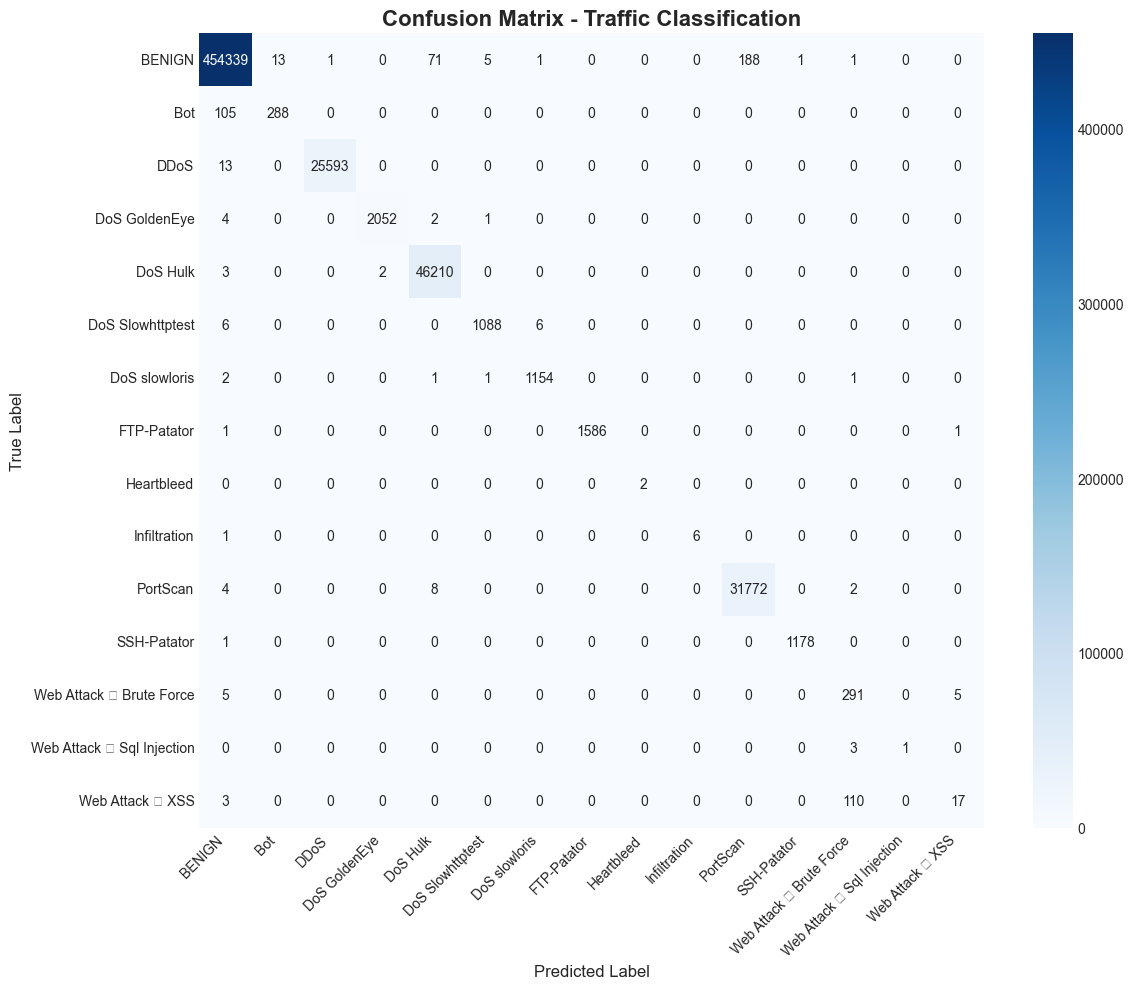

In [17]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Traffic Classification', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. WHY: SHAP Explanations

In [18]:
# Initialize SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.TreeExplainer(model)

# Calculate SHAP values (use sample for faster computation)
X_test_sample = X_test.sample(n=min(1000, len(X_test)), random_state=42)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_sample)  # Try without .values first

# Debug: Check shapes
print(f"X_test_sample shape: {X_test_sample.shape}")
print(f"Type of shap_values: {type(shap_values)}")
print(f"Length of shap_values list: {len(shap_values)}")
print(f"Shape of shap_values[0]: {shap_values[0].shape}")
print("SHAP values calculated!")

Initializing SHAP explainer...
X_test_sample shape: (1000, 78)
Type of shap_values: <class 'numpy.ndarray'>
Length of shap_values list: 1000
Shape of shap_values[0]: (78, 15)
SHAP values calculated!


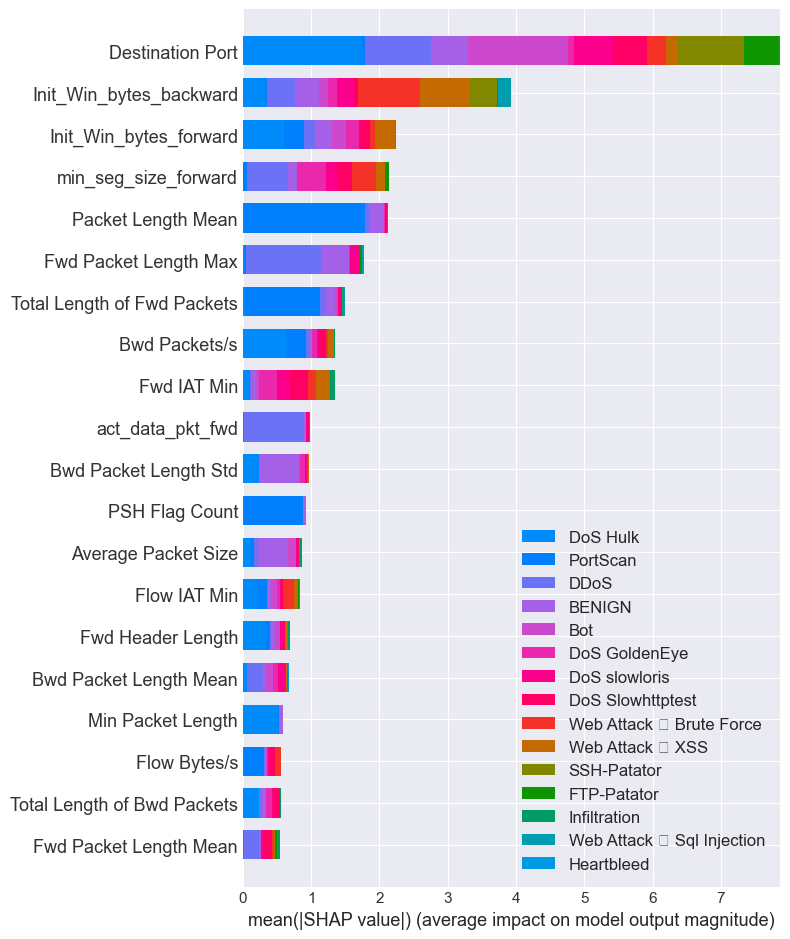

In [19]:
# SHAP Summary Plot - Global Feature Importance
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", class_names=le.classes_)


SHAP Analysis for class: BENIGN


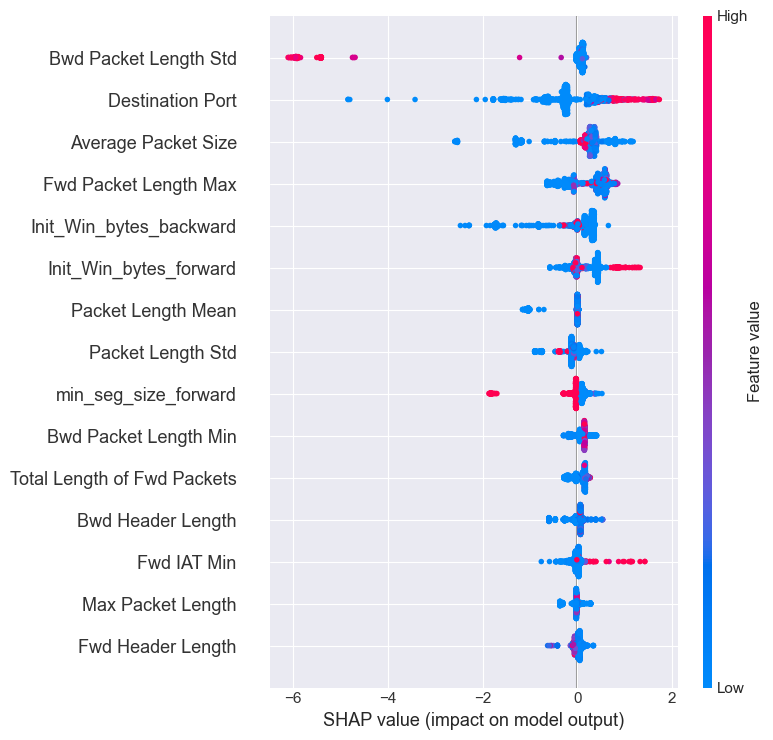


SHAP Analysis for class: Bot


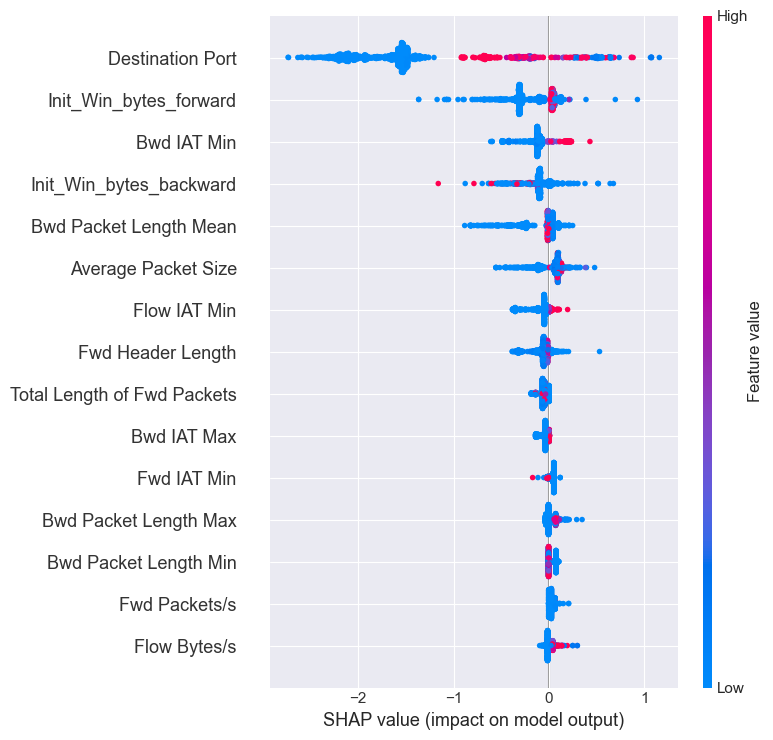


SHAP Analysis for class: DDoS


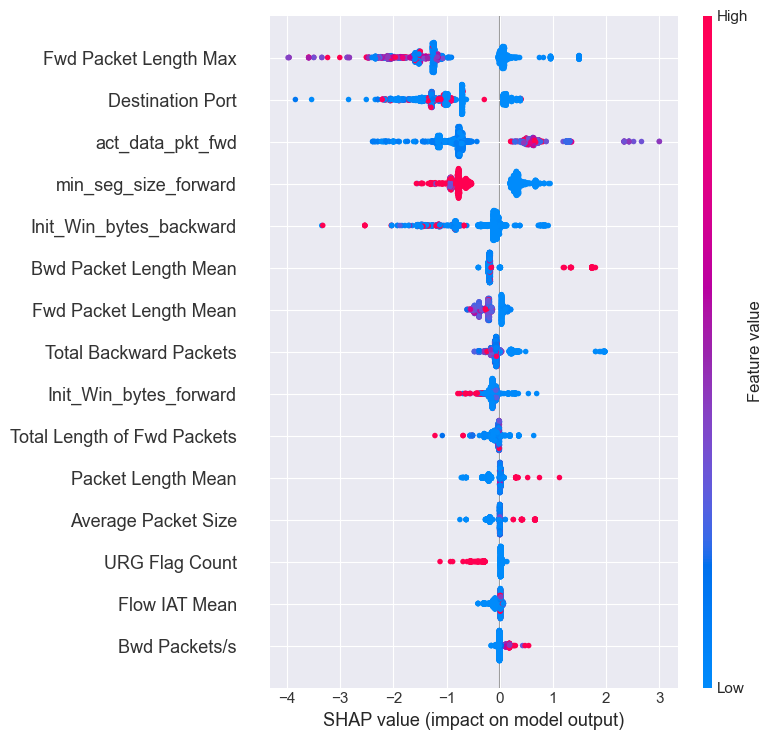


SHAP Analysis for class: DoS GoldenEye


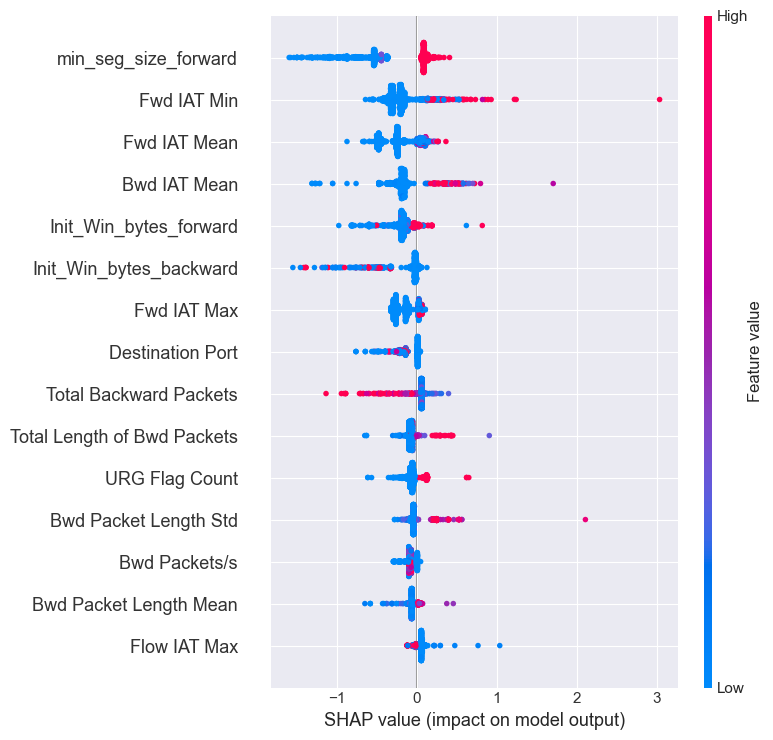


SHAP Analysis for class: DoS Hulk


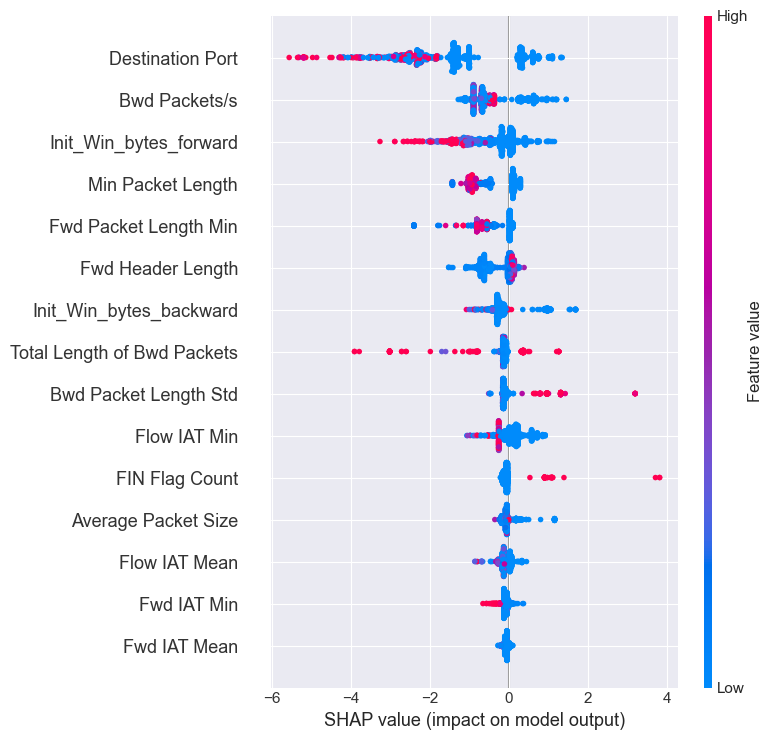

In [20]:
# SHAP Summary Plot - Feature Impact
for i, class_name in enumerate(le.classes_[:5]):  # Show first 5 classes
    print(f"\nSHAP Analysis for class: {class_name}")
    # Extract SHAP values for class i: use [:, :, i] not [i]
    shap.summary_plot(shap_values[:, :, i], X_test_sample, max_display=15)

Explaining prediction for sample 0
Predicted class: BENIGN


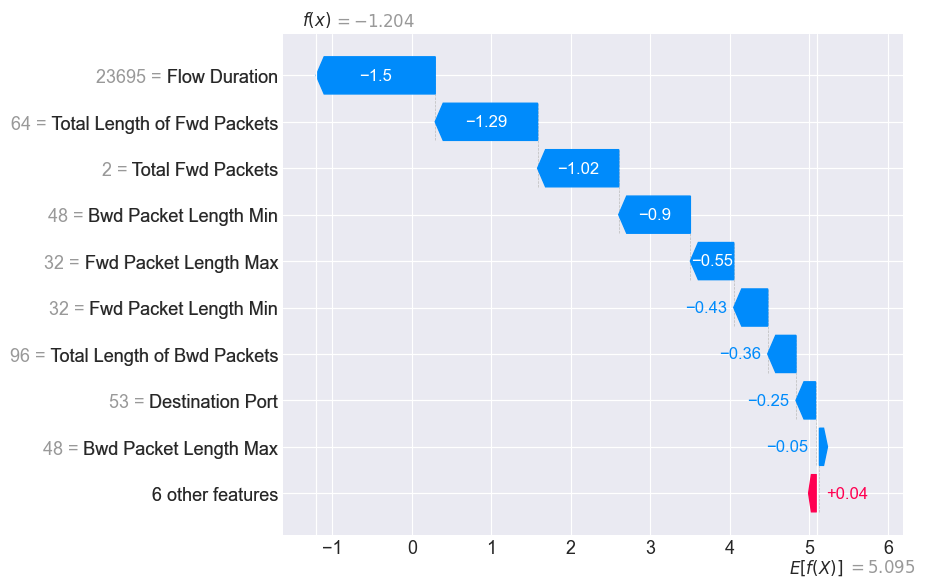

In [21]:
# Individual prediction explanation - Waterfall plot
sample_idx = 0
predicted_class = model.predict(X_test_sample.iloc[[sample_idx]])[0]

print(f"Explaining prediction for sample {sample_idx}")
print(f"Predicted class: {le.classes_[predicted_class]}")

shap.waterfall_plot(shap.Explanation(
    values=shap_values[predicted_class][sample_idx],
    base_values=explainer.expected_value[predicted_class],
    data=X_test_sample.iloc[sample_idx],
    feature_names=X_test_sample.columns.tolist()
))

## 6. HOW: Attack Pattern Analysis

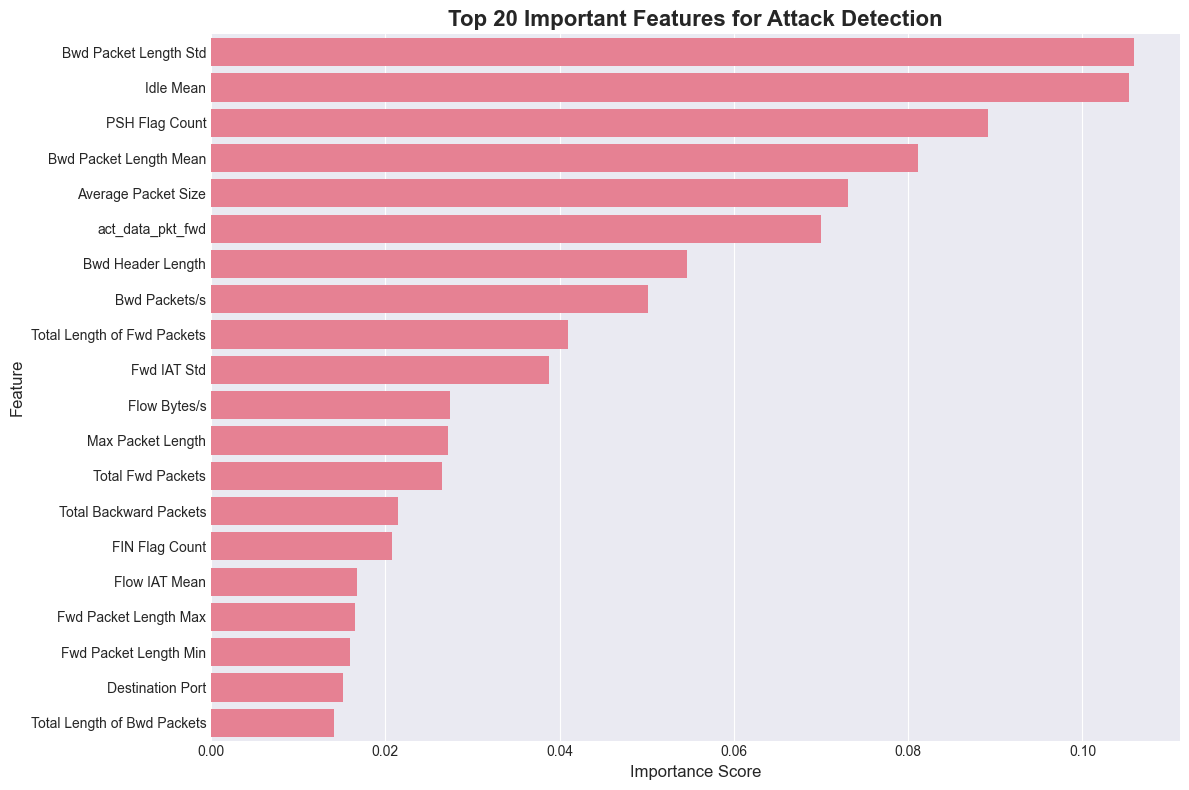


Top 10 Features:
                        feature  importance
13        Bwd Packet Length Std    0.105896
74                    Idle Mean    0.105393
46               PSH Flag Count    0.089182
12       Bwd Packet Length Mean    0.081086
52          Average Packet Size    0.073098
68             act_data_pkt_fwd    0.070046
35            Bwd Header Length    0.054586
37                Bwd Packets/s    0.050104
4   Total Length of Fwd Packets    0.040911
22                  Fwd IAT Std    0.038827


In [22]:
# Feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Important Features for Attack Detection', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10))

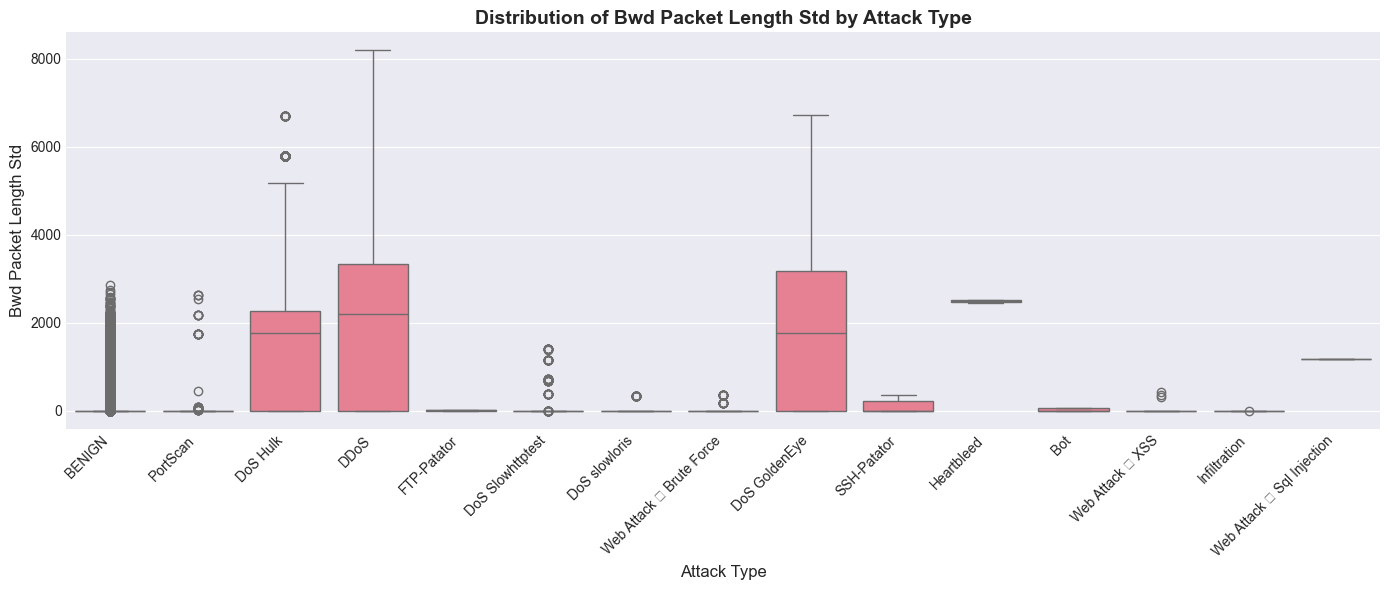

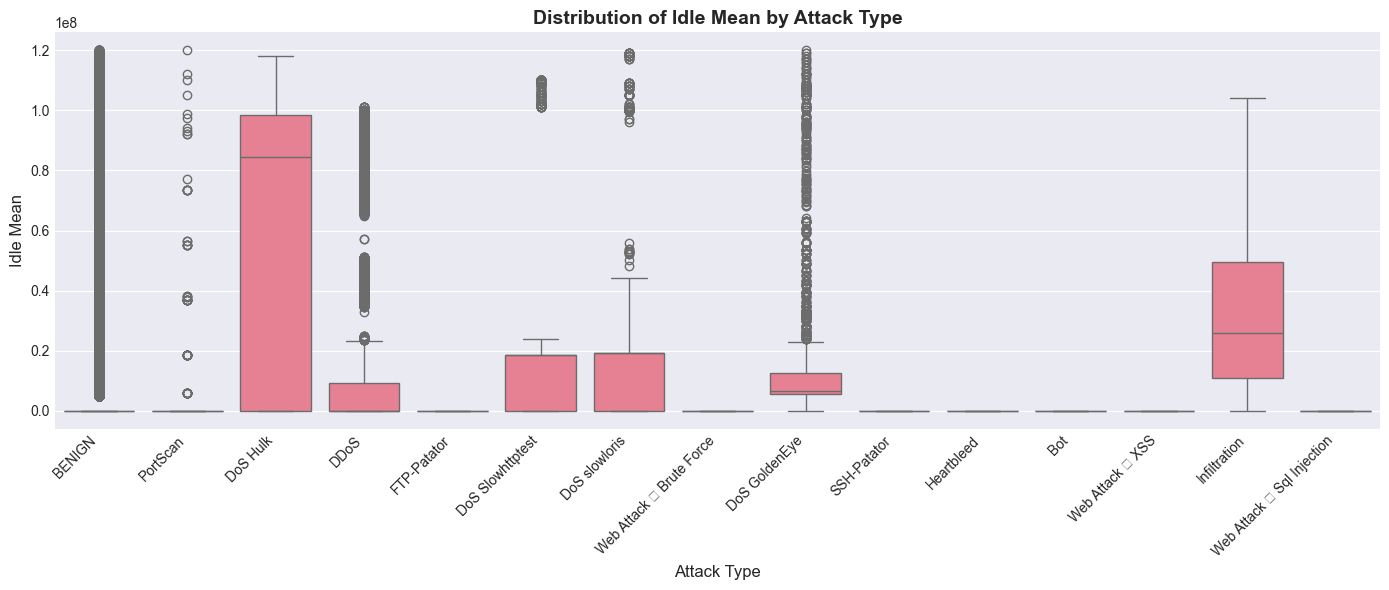

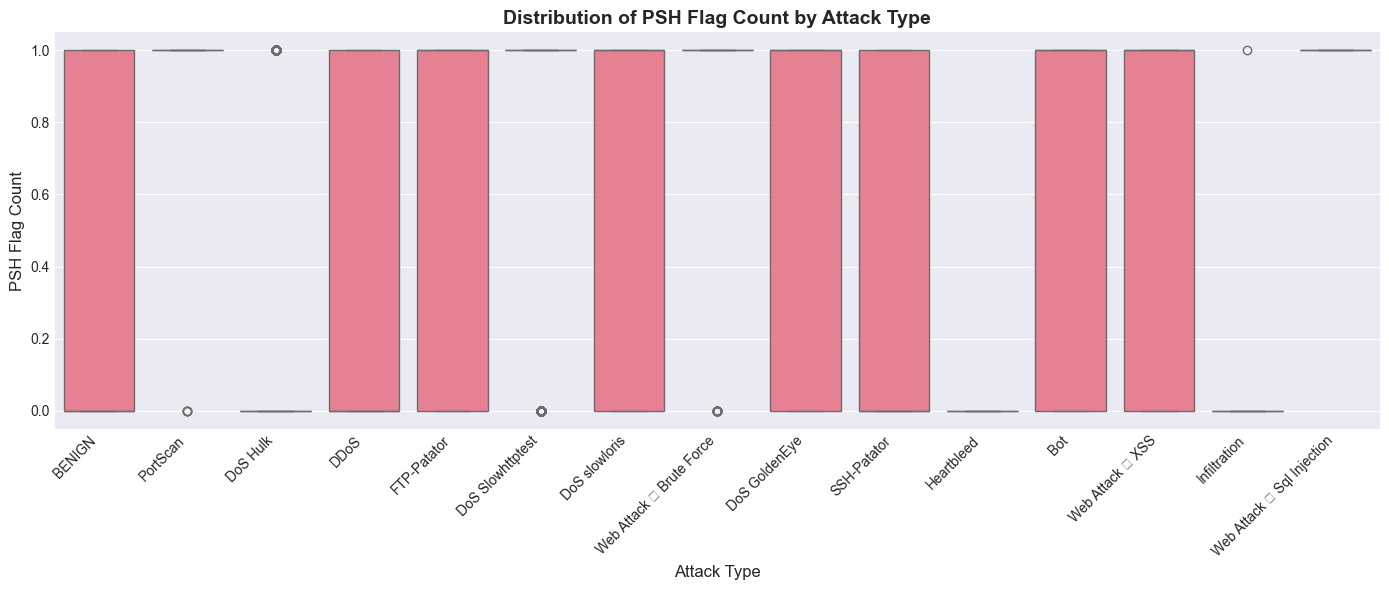

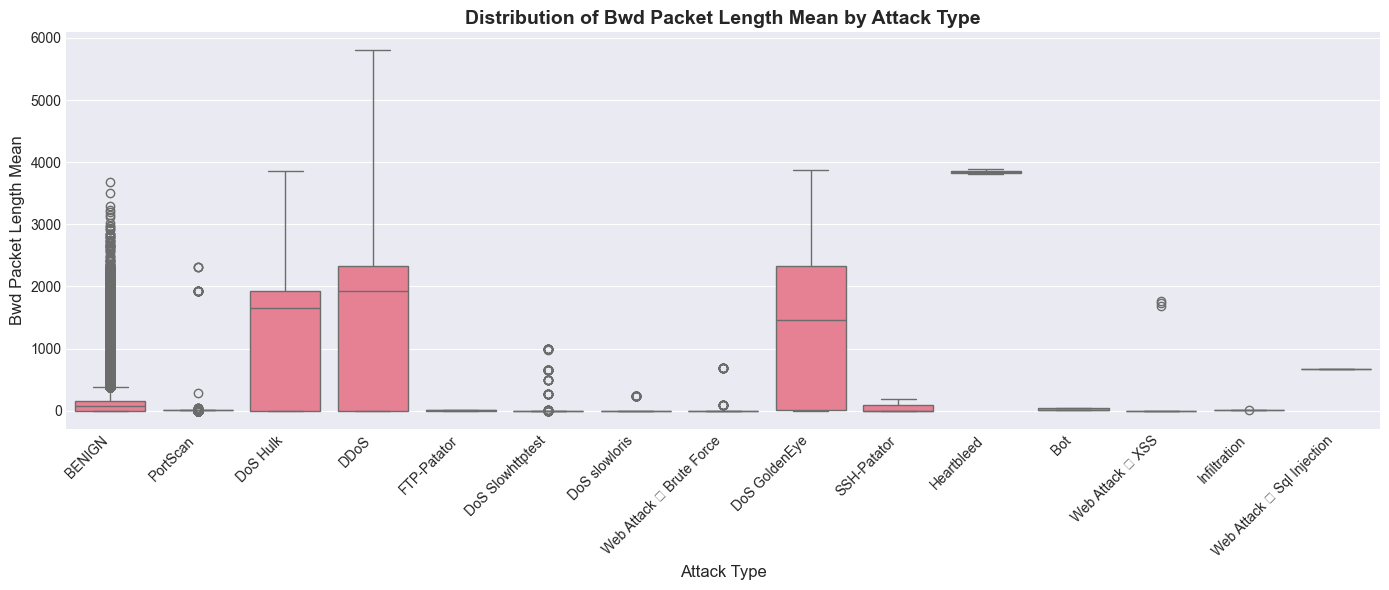

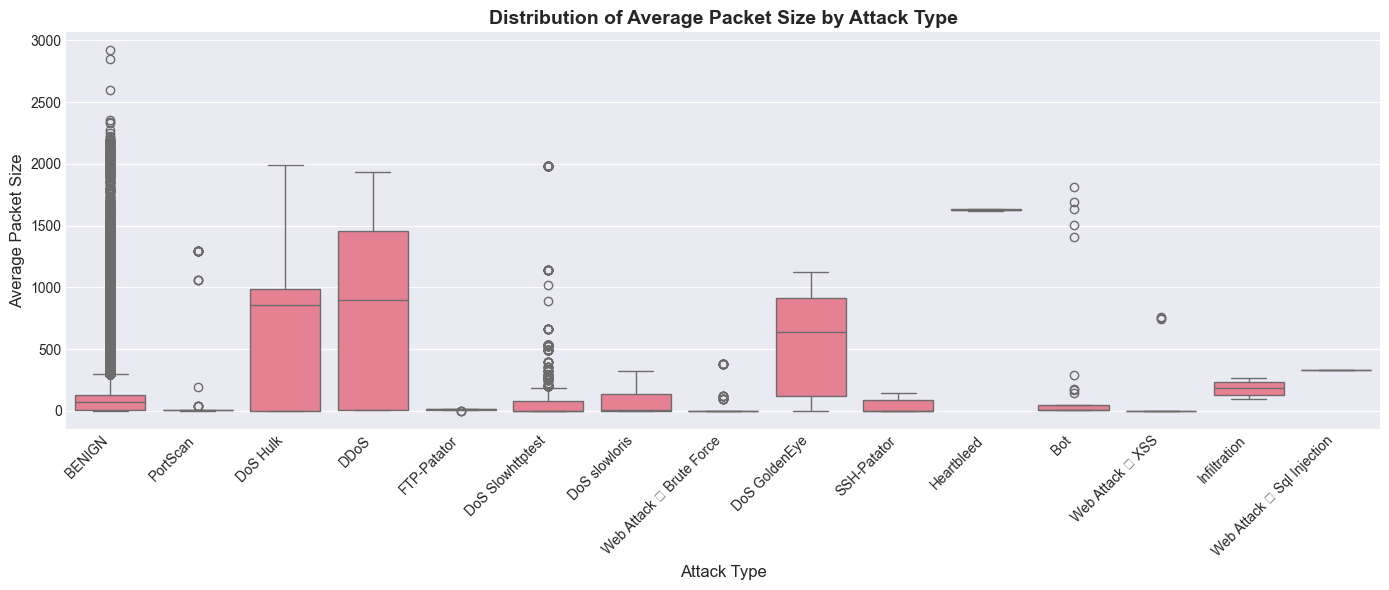

In [23]:
# Attack pattern analysis - Feature statistics by class
top_features = feature_importance.head(5)['feature'].tolist()

# Combine test data with predictions for analysis
analysis_df = X_test.copy()
analysis_df['Predicted_Class'] = le.inverse_transform(y_pred)

for feature in top_features:
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=analysis_df, x='Predicted_Class', y=feature)
    plt.title(f'Distribution of {feature} by Attack Type', fontsize=14, fontweight='bold')
    plt.xlabel('Attack Type', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 7. WHEN: Temporal Analysis

Temporal features found: ['Flow Duration', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min']


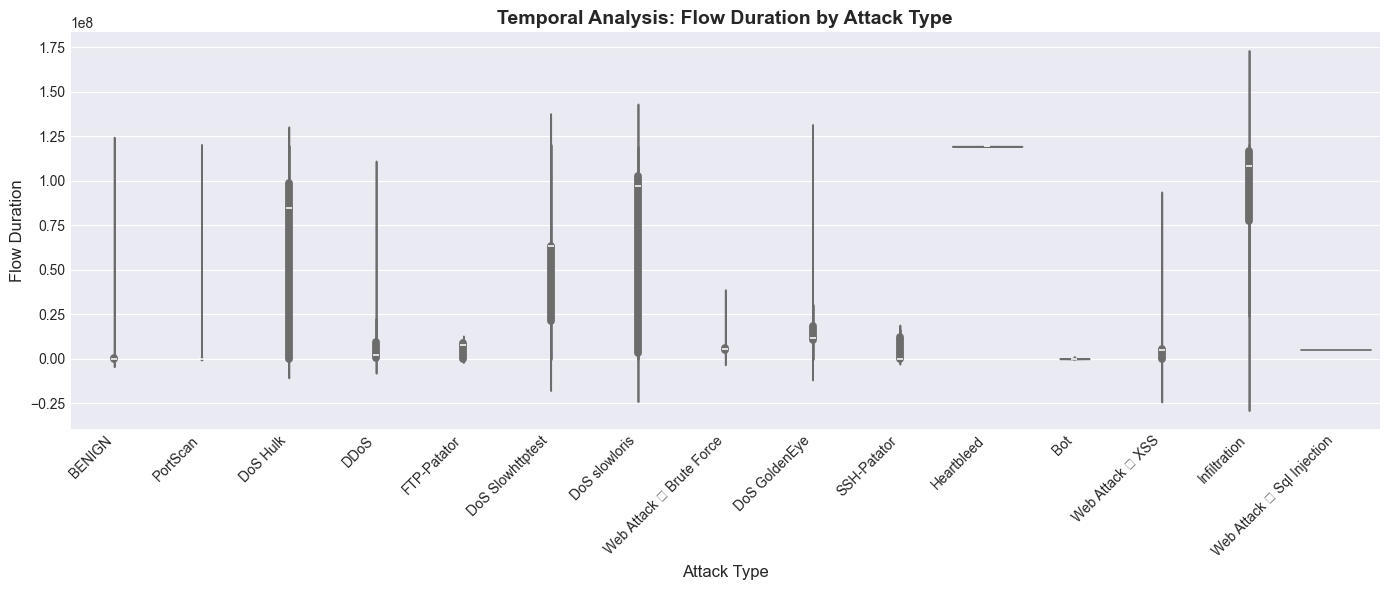

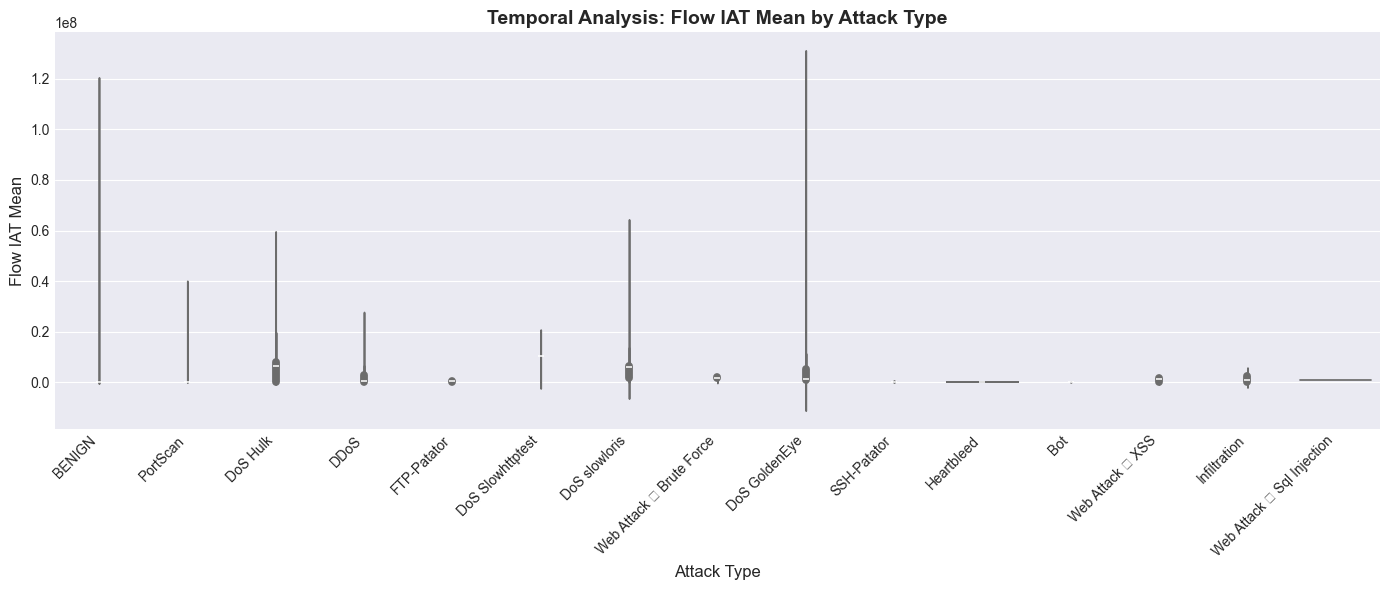

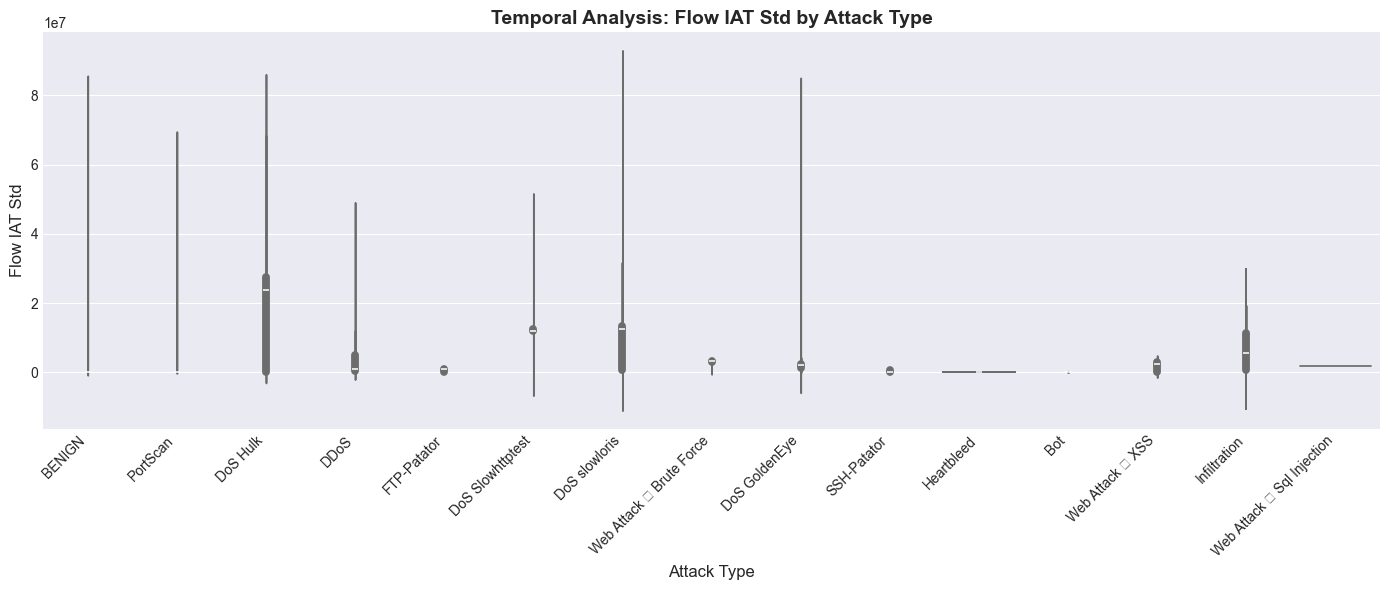

In [24]:
# Temporal feature analysis
temporal_cols = [col for col in X_numeric.columns if 'Duration' in col or 'IAT' in col or 'Time' in col]

if temporal_cols:
    print(f"Temporal features found: {temporal_cols}")

    for col in temporal_cols[:3]:  # Analyze first 3 temporal features
        plt.figure(figsize=(14, 6))
        sns.violinplot(data=analysis_df, x='Predicted_Class', y=col)
        plt.title(f'Temporal Analysis: {col} by Attack Type', fontsize=14, fontweight='bold')
        plt.xlabel('Attack Type', fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("No explicit temporal features found in dataset")

## 8. WHERE: Network Location Analysis

In [25]:
# Port analysis
port_cols = [col for col in X_numeric.columns if 'Port' in col]

if port_cols:
    print(f"Port-related features: {port_cols}")

    for col in port_cols:
        top_ports = analysis_df.groupby('Predicted_Class')[col].apply(
            lambda x: x.value_counts().head(5)
        )

        print(f"\nTop ports for {col}:")
        print(top_ports)
else:
    print("Port information not available in numeric features")

# Protocol analysis
protocol_cols = [col for col in X_numeric.columns if 'Protocol' in col]
if protocol_cols:
    print(f"\nProtocol features: {protocol_cols}")

Port-related features: ['Destination Port']

Top ports for Destination Port:
Predicted_Class                  
BENIGN                      53       191086
                            443      101377
                            80        47199
                            123        4766
                            22         2201
Bot                         8080        164
                            53931         1
                            51695         1
                            3836          1
                            52713         1
DDoS                        80        25594
DoS GoldenEye               80         2054
DoS Hulk                    80        46291
                            22            1
DoS Slowhttptest            80         1095
DoS slowloris               80         1161
FTP-Patator                 21         1586
Heartbleed                  444           2
Infiltration                444           6
PortScan                    80           74
         

## 9. WHO: Actor Profiling

Attack Behavior Profiles:
                           Bwd Packet Length Std                  Idle Mean  \
                                            mean          std          mean   
Predicted_Class                                                               
Bot                                    34.327731    35.472617  0.000000e+00   
DDoS                                 2090.542365  1871.044504  1.192330e+07   
DoS GoldenEye                        1952.055219  1568.299843  1.851320e+07   
DoS Hulk                             1627.897295  1325.086001  5.584533e+07   
DoS Slowhttptest                       54.407675   235.737421  3.029492e+07   
DoS slowloris                          10.097963    54.941424  2.766886e+07   
FTP-Patator                             7.376032     7.276713  0.000000e+00   
Heartbleed                           2491.697358    45.718828  0.000000e+00   
Infiltration                            0.585386     1.433898  3.642400e+07   
PortScan                  

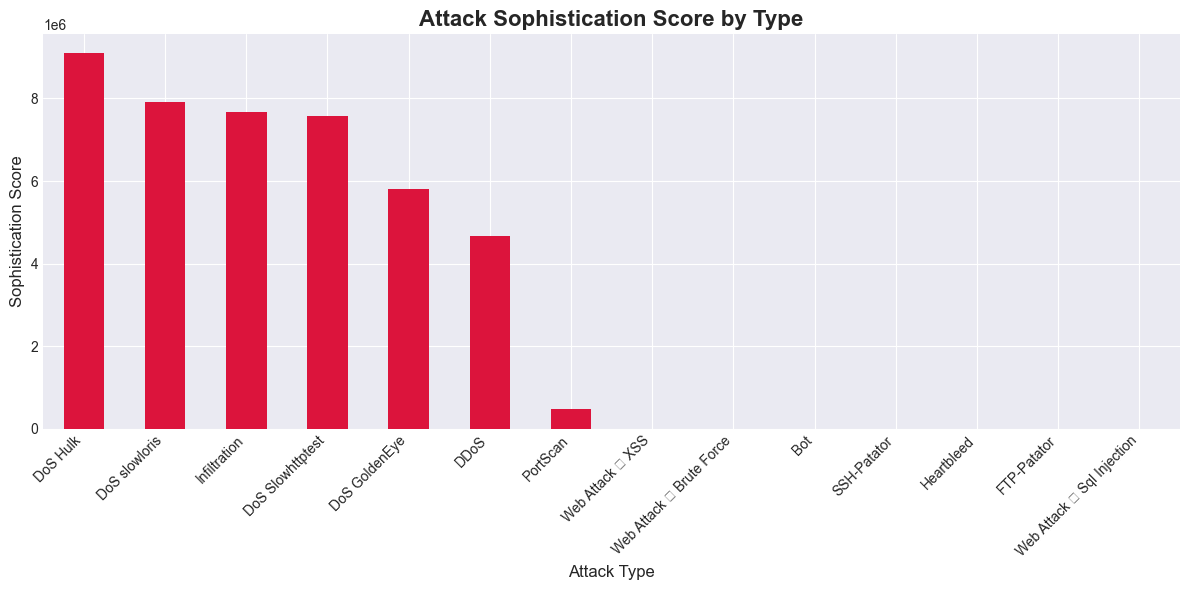

In [26]:
# Attacker behavior profiling based on feature patterns
attack_profiles = analysis_df[analysis_df['Predicted_Class'] != 'BENIGN'].groupby('Predicted_Class').agg({
    **{feat: ['mean', 'std'] for feat in top_features}
})

print("Attack Behavior Profiles:")
print(attack_profiles)

# Attack sophistication score based on feature diversity
attack_stats = analysis_df[analysis_df['Predicted_Class'] != 'BENIGN'].groupby('Predicted_Class').agg({
    feat: 'std' for feat in top_features
})

attack_stats['Sophistication_Score'] = attack_stats.mean(axis=1)
attack_stats = attack_stats.sort_values('Sophistication_Score', ascending=False)

plt.figure(figsize=(12, 6))
attack_stats['Sophistication_Score'].plot(kind='bar', color='crimson')
plt.title('Attack Sophistication Score by Type', fontsize=16, fontweight='bold')
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Sophistication Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 10. Summary & Actionable Insights

In [27]:
print("="*80)
print("COMPREHENSIVE TRAFFIC ANALYSIS SUMMARY")
print("="*80)

print(f"\n1. WHAT - Classification Results:")
print(f"   - Model Accuracy: {accuracy*100:.2f}%")
print(f"   - Number of classes detected: {len(le.classes_)}")
print(f"   - Classes: {', '.join(le.classes_)}")

print(f"\n2. WHY - Key Factors:")
print(f"   - Top 3 discriminative features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"     • {row['feature']}: {row['importance']:.4f}")

print(f"\n3. HOW - Attack Patterns:")
print(f"   - Feature importance analysis reveals distinct attack signatures")
print(f"   - Each attack type shows unique statistical patterns")

print(f"\n4. WHEN - Temporal Insights:")
print(f"   - Temporal features analyzed: {len(temporal_cols) if temporal_cols else 0}")

print(f"\n5. WHERE - Network Location:")
print(f"   - Port-based features analyzed: {len(port_cols) if port_cols else 0}")

print(f"\n6. WHO - Actor Profiling:")
print(f"   - Attack sophistication ranking completed")
print(f"   - Behavioral profiles created for each attack type")

print("\n" + "="*80)
print("RECOMMENDATIONS:")
print("="*80)
print("• Monitor the top 5 features for anomaly detection")
print("• Implement rate limiting for high-volume attack types (DDoS)")
print("• Enhanced logging for sophisticated attack patterns")
print("• Deploy SHAP-based real-time explainability for security analysts")
print("="*80)

COMPREHENSIVE TRAFFIC ANALYSIS SUMMARY

1. WHAT - Classification Results:
   - Model Accuracy: 99.90%
   - Number of classes detected: 15
   - Classes: BENIGN, Bot, DDoS, DoS GoldenEye, DoS Hulk, DoS Slowhttptest, DoS slowloris, FTP-Patator, Heartbleed, Infiltration, PortScan, SSH-Patator, Web Attack � Brute Force, Web Attack � Sql Injection, Web Attack � XSS

2. WHY - Key Factors:
   - Top 3 discriminative features:
     • Bwd Packet Length Std: 0.1059
     • Idle Mean: 0.1054
     • PSH Flag Count: 0.0892

3. HOW - Attack Patterns:
   - Feature importance analysis reveals distinct attack signatures
   - Each attack type shows unique statistical patterns

4. WHEN - Temporal Insights:
   - Temporal features analyzed: 15

5. WHERE - Network Location:
   - Port-based features analyzed: 1

6. WHO - Actor Profiling:
   - Attack sophistication ranking completed
   - Behavioral profiles created for each attack type

RECOMMENDATIONS:
• Monitor the top 5 features for anomaly detection
• Implem

In [28]:
import json

def analyze_traffic_sample(sample_idx, X_sample, y_true, y_pred, y_pred_proba, shap_values, feature_names, class_names):
    """
    Comprehensive 5W+1H analysis of a traffic sample
    """
    # WHAT: Classification
    predicted_class = class_names[y_pred[sample_idx]]
    true_class = class_names[y_true[sample_idx]]
    confidence = y_pred_proba[sample_idx][y_pred[sample_idx]] * 100

    # WHY: SHAP explanation
    sample_shap = shap_values[:, :, y_pred[sample_idx]][sample_idx]
    top_features_idx = np.argsort(np.abs(sample_shap))[-5:][::-1]

    why_explanation = []
    for idx in top_features_idx:
        why_explanation.append({
            "feature": feature_names[idx],
            "value": float(X_sample[sample_idx, idx]),
            "shap_value": float(sample_shap[idx]),
            "impact": "positive" if sample_shap[idx] > 0 else "negative"
        })

    # HOW: Attack pattern analysis
    feature_dict = dict(zip(feature_names, X_sample[sample_idx]))

    how_analysis = {
        "protocol": int(feature_dict.get('Protocol', 0)),
        "flow_duration": float(feature_dict.get('Flow Duration', 0)),
        "total_packets": float(feature_dict.get('Total Fwd Packets', 0) + feature_dict.get('Total Backward Packets', 0)),
        "packet_rate": float(feature_dict.get('Flow Packets/s', 0)) if 'Flow Packets/s' in feature_dict else "N/A",
        "avg_packet_size": float(feature_dict.get('Average Packet Size', 0)) if 'Average Packet Size' in feature_dict else "N/A"
    }

    # WHEN: Temporal analysis (if temporal features exist)
    when_analysis = {
        "flow_duration_ms": float(feature_dict.get('Flow Duration', 0)),
        "flow_IAT_mean": float(feature_dict.get('Flow IAT Mean', 0)) if 'Flow IAT Mean' in feature_dict else "N/A",
        "note": "Exact timestamp not available in processed features"
    }

    # WHERE: Network location
    where_analysis = {
        "destination_port": int(feature_dict.get('Destination Port', 0)),
        "source_port": "Not available in processed features",
        "note": "IP addresses removed during preprocessing for privacy"
    }

    # WHO: Actor profiling
    who_analysis = {
        "attack_type": predicted_class,
        "sophistication": "high" if "DDoS" in predicted_class or "Infiltration" in predicted_class else "medium" if "DoS" in predicted_class else "low",
        "note": "Source IP analysis not available in processed features"
    }

    return {
        "sample_index": int(sample_idx),
        "WHAT": {
            "predicted_classification": predicted_class,
            "true_classification": true_class,
            "confidence_percent": float(confidence),
            "correct_prediction": predicted_class == true_class
        },
        "WHY": {
            "explanation": "Top 5 features influencing this classification",
            "key_features": why_explanation
        },
        "HOW": {
            "attack_mechanism": how_analysis,
            "description": f"Attack characterized by protocol {how_analysis['protocol']} with packet rate and flow patterns"
        },
        "WHEN": when_analysis,
        "WHERE": where_analysis,
        "WHO": who_analysis
    }

In [29]:
# Analyze first 10 samples from test set
num_samples = min(10, len(y_pred))
analyses = []

print(f"Analyzing {num_samples} samples...")

for i in range(num_samples):
    try:
        analysis = analyze_traffic_sample(
            sample_idx=i,
            X_sample=X_test.values,  # X_test is DataFrame, use .values
            y_true=y_test,  # y_test is already numpy array
            y_pred=y_pred,  # Already numpy array
            y_pred_proba=y_pred_proba,  # Already numpy array
            shap_values=shap_values,  # Already numpy array
            feature_names=X_test.columns.tolist(),
            class_names=le.classes_
        )
        analyses.append(analysis)
        print(f"✓ Sample {i+1}/{num_samples} analyzed")
    except Exception as e:
        print(f"✗ Error analyzing sample {i}: {str(e)}")

# Create JSON output
json_output = {
    "analysis_metadata": {
        "model": "XGBoost Multi-class Classifier",
        "dataset": "CICIDS2017",
        "num_samples_analyzed": len(analyses),
        "num_classes": len(le.classes_),
        "classes": le.classes_.tolist()
    },
    "samples": analyses
}

# Pretty print JSON
print("\n" + "="*50)
print(f"Successfully analyzed {len(analyses)} samples!")
print("="*50)
print(json.dumps(json_output, indent=2)[:2000] + "...")  # Print first 2000 chars

Analyzing 10 samples...
✓ Sample 1/10 analyzed
✓ Sample 2/10 analyzed
✓ Sample 3/10 analyzed
✓ Sample 4/10 analyzed
✓ Sample 5/10 analyzed
✓ Sample 6/10 analyzed
✓ Sample 7/10 analyzed
✓ Sample 8/10 analyzed
✓ Sample 9/10 analyzed
✓ Sample 10/10 analyzed

Successfully analyzed 10 samples!
{
  "analysis_metadata": {
    "model": "XGBoost Multi-class Classifier",
    "dataset": "CICIDS2017",
    "num_samples_analyzed": 10,
    "num_classes": 15,
    "classes": [
      "BENIGN",
      "Bot",
      "DDoS",
      "DoS GoldenEye",
      "DoS Hulk",
      "DoS Slowhttptest",
      "DoS slowloris",
      "FTP-Patator",
      "Heartbleed",
      "Infiltration",
      "PortScan",
      "SSH-Patator",
      "Web Attack \ufffd Brute Force",
      "Web Attack \ufffd Sql Injection",
      "Web Attack \ufffd XSS"
    ]
  },
  "samples": [
    {
      "sample_index": 0,
      "WHAT": {
        "predicted_classification": "BENIGN",
        "true_classification": "BENIGN",
        "confidence_percent": 

In [30]:
# Save to JSON file
output_file = "traffic_analysis_results.json"
with open(output_file, 'w') as f:
    json.dump(json_output, f, indent=2)

print(f"\nAnalysis saved to: {output_file}")
print(f"Total samples analyzed: {len(analyses)}")
print(f"File size: {os.path.getsize(output_file)} bytes")


Analysis saved to: traffic_analysis_results.json
Total samples analyzed: 10
File size: 22283 bytes


In [31]:
# Find DDoS samples in test set
ddos_class_idx = list(le.classes_).index('DDoS')
ddos_indices = np.where(y_pred == ddos_class_idx)[0]

print(f"Found {len(ddos_indices)} DDoS predictions in test set")
print(f"Analyzing first DDoS sample...\n")

if len(ddos_indices) > 0:
    # Analyze first DDoS sample
    ddos_sample_idx = ddos_indices[0]

    ddos_analysis = analyze_traffic_sample(
        sample_idx=ddos_sample_idx,
        X_sample=X_test.values,
        y_true=y_test,
        y_pred=y_pred,
        y_pred_proba=y_pred_proba,
        shap_values=shap_values,
        feature_names=X_test.columns.tolist(),
        class_names=le.classes_
    )

    # Create focused JSON output for DDoS
    ddos_json = {
        "analysis_type": "DDoS Attack Example",
        "sample": ddos_analysis
    }

    # Pretty print
    print("="*60)
    print("DDoS ATTACK ANALYSIS - JSON OUTPUT")
    print("="*60)
    print(json.dumps(ddos_json, indent=2))

    # Also save to separate file
    with open("ddos_example_analysis.json", 'w') as f:
        json.dump(ddos_json, f, indent=2)
    print("\n✓ Saved to: ddos_example_analysis.json")
else:
    print("No DDoS samples found in predictions!")

Found 25594 DDoS predictions in test set
Analyzing first DDoS sample...

DDoS ATTACK ANALYSIS - JSON OUTPUT
{
  "analysis_type": "DDoS Attack Example",
  "sample": {
    "sample_index": 11,
    "WHAT": {
      "predicted_classification": "DDoS",
      "true_classification": "DDoS",
      "confidence_percent": 99.98162078857422,
      "correct_prediction": true
    },
    "WHY": {
      "explanation": "Top 5 features influencing this classification",
      "key_features": [
        {
          "feature": "act_data_pkt_fwd",
          "value": 4.0,
          "shap_value": -1.5795331001281738,
          "impact": "negative"
        },
        {
          "feature": "Destination Port",
          "value": 80.0,
          "shap_value": -1.137149691581726,
          "impact": "negative"
        },
        {
          "feature": "min_seg_size_forward",
          "value": 20.0,
          "shap_value": -1.0787593126296997,
          "impact": "negative"
        },
        {
          "feature": 

In [32]:

import joblib

# Export the trained XGBoost model to joblib format
model_filename = 'xgboost_traffic_model.pkl'
le_filename = 'label_encoder.pkl'

print("Exporting model and encoder...")
print("=" * 60)

# Save the trained model
joblib.dump(model, model_filename)
print(f"✓ Model exported to: {model_filename}")
print(f"  - Model type: {type(model).__name__}")
print(f"  - Accuracy: {accuracy*100:.2f}%")

# Save the label encoder (needed to decode predictions)
joblib.dump(le, le_filename)
print(f"\n✓ Label Encoder exported to: {le_filename}")
print(f"  - Number of classes: {len(le.classes_)}")

print("\n" + "=" * 60)
print("Export completed successfully!")
print("=" * 60)

# Show example loading code
print("\nTo load the model in the future:")
print("─" * 60)
print("import joblib")
print(f"model = joblib.load('{model_filename}')")
print(f"le = joblib.load('{le_filename}')")
print("\n# Make predictions")
print("predictions = model.predict(X_test)")
print("predicted_labels = le.inverse_transform(predictions)")

Exporting model and encoder...
✓ Model exported to: xgboost_traffic_model.pkl
  - Model type: XGBClassifier
  - Accuracy: 99.90%

✓ Label Encoder exported to: label_encoder.pkl
  - Number of classes: 15

Export completed successfully!

To load the model in the future:
────────────────────────────────────────────────────────────
import joblib
model = joblib.load('xgboost_traffic_model.pkl')
le = joblib.load('label_encoder.pkl')

# Make predictions
predictions = model.predict(X_test)
predicted_labels = le.inverse_transform(predictions)
